# Makine Öğrenmesi ile Maaş Tahmini

## İş Problemi
Maaş bilgileri ve 1986 yılına ait kariyer istatistikleri paylaşılan beyzbol oyuncularının maaş tahminleri için bir makine öğrenmesi modeli geliştiriniz.

## Veri Seti Hikayesi
Bu veri seti orijinal olarak Carnegie Mellon Üniversitesi'nde bulunan
StatLib kütüphanesinden alınmıştır. Veri seti 1988 ASA Grafik Bölümü
Poster Oturumu'nda kullanılan verilerin bir parçasıdır. Maaş verileri
orijinal olarak Sports Illustrated, 20 Nisan 1987'den alınmıştır. 1986 ve
kariyer istatistikleri, Collier Books, Macmillan Publishing Company,
New York tarafından yayınlanan 1987 Beyzbol Ansiklopedisi
Güncellemesinden elde edilmiştir.

## Değişkenler
- AtBat 1986-1987 sezonunda bir beyzbol sopası ile topa yapılan vuruş sayısı
- Hits 1986-1987 sezonundaki isabet sayısı
- HmRun 1986-1987 sezonundaki en değerli vuruş sayısı
- Runs 1986-1987 sezonunda takımına kazandırdığı sayı
- RBI Bir vurucunun vuruş yaptıgında koşu yaptırdığı oyuncu sayısı
- Walks Karşı oyuncuya yaptırılan hata sayısı
- Years Oyuncunun major liginde oynama süresi (sene)
- CAtBat Oyuncunun kariyeri boyunca topa vurma sayısı
- CHits Oyuncunun kariyeri boyunca yaptığı isabetli vuruş sayısı
- CHmRun Oyucunun kariyeri boyunca yaptığı en değerli sayısı
- CRuns Oyuncunun kariyeri boyunca takımına kazandırdığı sayı
- CRBI Oyuncunun kariyeri boyunca koşu yaptırdırdığı oyuncu sayısı
- CWalks Oyuncun kariyeri boyunca karşı oyuncuya yaptırdığı hata sayısı
- League Oyuncunun sezon sonuna kadar oynadığı ligi gösteren A ve N seviyelerine sahip bir faktör
- Division 1986 sonunda oyuncunun oynadığı pozisyonu gösteren E ve W seviyelerine sahip bir faktör
- PutOuts Oyun icinde takım arkadaşınla yardımlaşma
- Assits 1986-1987 sezonunda oyuncunun yaptığı asist sayısı
- Errors 1986-1987 sezonundaki oyuncunun hata sayısı
- Salary Oyuncunun 1986-1987 sezonunda aldığı maaş(bin uzerinden)
- NewLeague 1987 sezonunun başında oyuncunun ligini gösteren A ve N seviyelerine sahip bir faktör

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = pd.read_csv("datasets/hitters.csv")
df.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.00,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.00,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.00,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.50,N


# Genel Resim

In [2]:
def checkDf(dataframe, head = 8):
  print("##### Shape #####")
  print(dataframe.shape)
  print("\n##### Types #####")
  print(dataframe.dtypes)
  print("\n##### Tail #####")
  print(dataframe.tail(head))
  print("\n##### Head #####")
  print(dataframe.head(head))
  print("\n##### Null Analysis #####")
  print(dataframe.isnull().sum())
  print("\n##### Quantiles #####")
  print(dataframe.describe([0,0.05, 0.50, 0.95, 0.99, 1]).T)  
checkDf(df)

##### Shape #####
(322, 20)

##### Types #####
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

##### Tail #####
     AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
314    408   117     11    66   41     34      1     408    117      11   
315    593   172     22    82  100     57      1     593    172      22   
316    221    53      2    21   23     22      8    1063    283      15   
317    497   127      7    65   48     37      5    2703    806      32   
318    492   136      5    76   50     94     12    5511   1511      39   
319    475   126      3    61   43     52      6   

# Numerik ve Kategorik Değişkenlerin Yakalanması

In [3]:
def grabColNames(dataframe, catTh=10, carTh=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        catTh: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        carTh: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        catCols: list
                Kategorik değişken listesi
        numCols: list
                Numerik değişken listesi
        catButCar: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grabColNames(df))


    Notes
    ------
        catCols + numCols + catButCar = toplam değişken sayısı
        numButCat catCols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: catCols + numCols + catButCar = değişken sayısı

    """

    # catCols, catButCar
    catCols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    numButCat = [col for col in dataframe.columns if dataframe[col].nunique() < catTh and
                 dataframe[col].dtypes != "O"]
    catButCar = [col for col in dataframe.columns if dataframe[col].nunique() > carTh and
                 dataframe[col].dtypes == "O"]
    catCols = catCols + numButCat
    catCols = [col for col in catCols if col not in catButCar]

    # numCols
    numCols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numCols = [col for col in numCols if col not in numButCat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'catCols: {len(catCols)}')
    print(f'numCols: {len(numCols)}')
    print(f'catButCar: {len(catButCar)}')
    print(f'numButCat: {len(numButCat)}')
    return catCols, numCols, catButCar


catCols, numCols, catButCar = grabColNames(df)

Observations: 322
Variables: 20
catCols: 3
numCols: 17
catButCar: 0
numButCat: 0


In [4]:
catCols

['League', 'Division', 'NewLeague']

In [5]:
numCols

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'Salary']

# Numerik ve Kategorik Değişkenlerin Analizi

   League  Ratio
A     175  54.35
N     147  45.65
##########################################


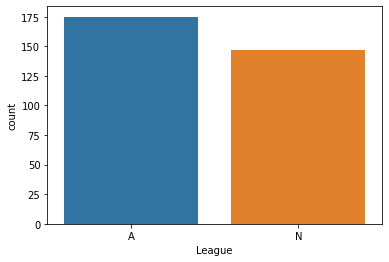

   Division  Ratio
W       165  51.24
E       157  48.76
##########################################


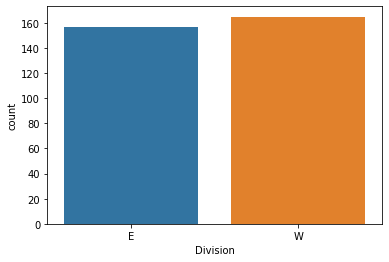

   NewLeague  Ratio
A        176  54.66
N        146  45.34
##########################################


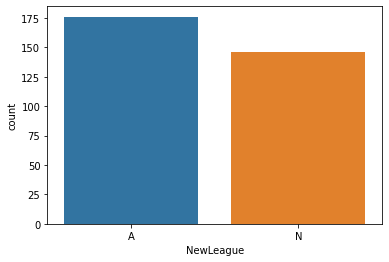

In [6]:
def catSummary(dataframe, colName, plot=False):
    print(pd.DataFrame({colName: dataframe[colName].value_counts(),
                        "Ratio": 100 * dataframe[colName].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[colName], data=dataframe)
        plt.show(block=True)
    
for col in catCols:
    if df[col].dtypes == "bool":
        print(col)
    else:
        catSummary(df, col, True)

count   322.00
mean    380.93
std     153.40
min      16.00
5%      161.00
10%     194.10
20%     221.80
30%     281.30
40%     321.80
50%     379.50
60%     430.20
70%     490.00
80%     535.60
90%     584.90
95%     609.90
99%     658.59
100%    687.00
max     687.00
Name: AtBat, dtype: float64


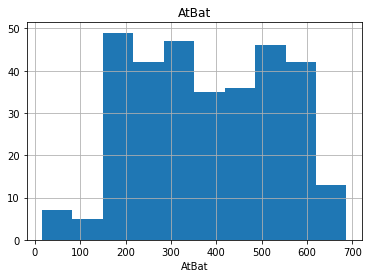

count   322.00
mean    101.02
std      46.45
min       1.00
5%       39.00
10%      45.10
20%      57.00
30%      70.00
40%      82.00
50%      96.00
60%     113.00
70%     128.70
80%     144.00
90%     163.00
95%     174.00
99%     210.79
100%    238.00
max     238.00
Name: Hits, dtype: float64


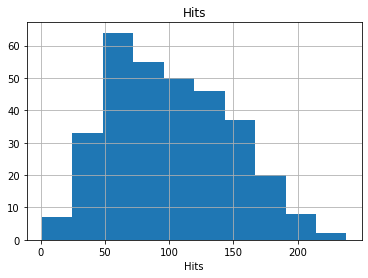

count   322.00
mean     10.77
std       8.71
min       0.00
5%        0.00
10%       1.00
20%       3.00
30%       5.00
40%       6.00
50%       8.00
60%      10.60
70%      14.00
80%      18.00
90%      24.00
95%      28.95
99%      33.00
100%     40.00
max      40.00
Name: HmRun, dtype: float64


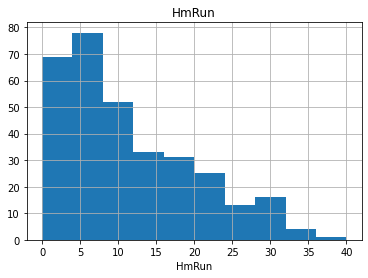

count   322.00
mean     50.91
std      26.02
min       0.00
5%       17.00
10%      20.10
20%      27.00
30%      33.00
40%      41.00
50%      48.00
60%      55.60
70%      66.00
80%      75.80
90%      89.00
95%      94.00
99%     107.79
100%    130.00
max     130.00
Name: Runs, dtype: float64


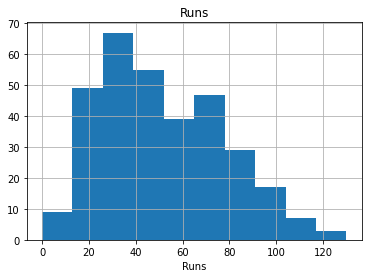

count   322.00
mean     48.03
std      26.17
min       0.00
5%       14.00
10%      19.00
20%      26.00
30%      30.00
40%      36.40
50%      44.00
60%      49.00
70%      58.00
80%      73.00
90%      86.00
95%      96.00
99%     112.37
100%    121.00
max     121.00
Name: RBI, dtype: float64


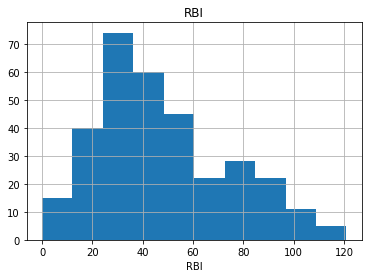

count   322.00
mean     38.74
std      21.64
min       0.00
5%       11.05
10%      15.00
20%      20.00
30%      24.00
40%      30.00
50%      35.00
60%      40.00
70%      48.70
80%      59.00
90%      69.90
95%      78.00
99%      93.58
100%    105.00
max     105.00
Name: Walks, dtype: float64


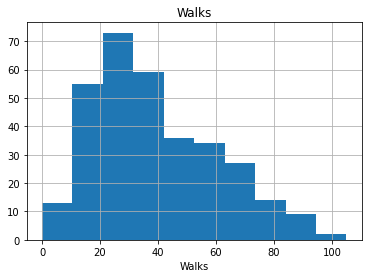

count   322.00
mean      7.44
std       4.93
min       1.00
5%        1.00
10%       2.00
20%       3.00
30%       4.00
40%       5.00
50%       6.00
60%       7.60
70%      10.00
80%      12.00
90%      15.00
95%      17.00
99%      19.79
100%     24.00
max      24.00
Name: Years, dtype: float64


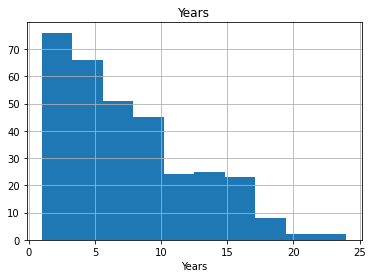

count     322.00
mean     2648.68
std      2324.21
min        19.00
5%        216.50
10%       342.20
20%       667.60
30%       963.40
40%      1402.20
50%      1928.00
60%      2654.00
70%      3365.00
80%      4483.00
90%      6123.40
95%      7125.60
99%      8749.97
100%    14053.00
max     14053.00
Name: CAtBat, dtype: float64


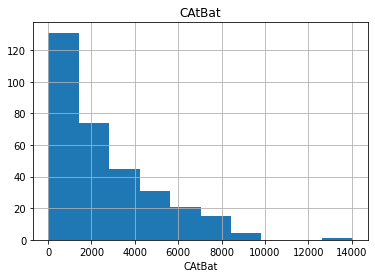

count    322.00
mean     717.57
std      654.47
min        4.00
5%        54.00
10%       86.00
20%      164.60
30%      238.00
40%      355.80
50%      508.00
60%      708.20
70%      911.10
80%     1229.20
90%     1659.60
95%     2017.15
99%     2500.34
100%    4256.00
max     4256.00
Name: CHits, dtype: float64


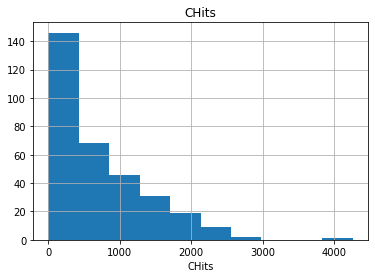

count   322.00
mean     69.49
std      86.27
min       0.00
5%        2.00
10%       4.00
20%      10.20
30%      16.30
40%      27.40
50%      37.50
60%      51.20
70%      72.40
80%     103.80
90%     194.90
95%     265.65
99%     373.12
100%    548.00
max     548.00
Name: CHmRun, dtype: float64


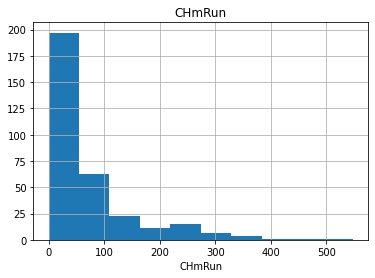

count    322.00
mean     358.80
std      334.11
min        1.00
5%        27.00
10%       38.10
20%       80.40
30%      117.30
40%      181.00
50%      247.00
60%      333.00
70%      443.40
80%      627.20
90%      895.70
95%     1032.30
99%     1174.37
100%    2165.00
max     2165.00
Name: CRuns, dtype: float64


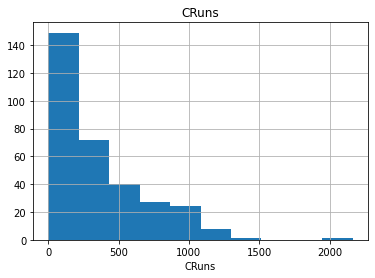

count    322.00
mean     330.12
std      333.22
min        0.00
5%        22.05
10%       34.10
20%       70.20
30%      106.30
40%      149.00
50%      220.50
60%      303.60
70%      379.10
80%      496.20
90%      861.60
95%     1071.75
99%     1310.85
100%    1659.00
max     1659.00
Name: CRBI, dtype: float64


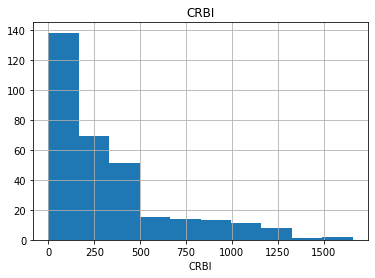

count    322.00
mean     260.24
std      267.06
min        0.00
5%        15.05
10%       30.10
20%       55.00
30%       82.00
40%      117.40
50%      170.50
60%      226.60
70%      300.70
80%      421.00
90%      643.90
95%      817.60
99%     1139.14
100%    1566.00
max     1566.00
Name: CWalks, dtype: float64


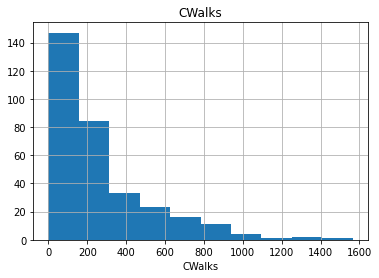

count    322.00
mean     288.94
std      280.70
min        0.00
5%        33.20
10%       62.20
20%       99.60
30%      132.00
40%      167.00
50%      212.00
60%      257.40
70%      303.00
80%      365.80
90%      685.60
95%      910.65
99%     1301.19
100%    1378.00
max     1378.00
Name: PutOuts, dtype: float64


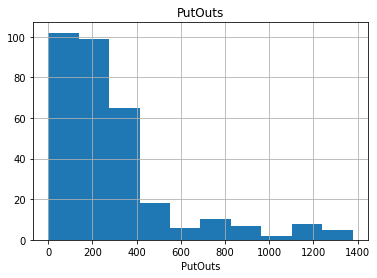

count   322.00
mean    106.91
std     136.85
min       0.00
5%        0.00
10%       2.00
20%       5.20
30%       9.00
40%      15.40
50%      39.50
60%      76.80
70%     134.80
80%     210.80
90%     353.30
95%     431.45
99%     478.16
100%    492.00
max     492.00
Name: Assists, dtype: float64


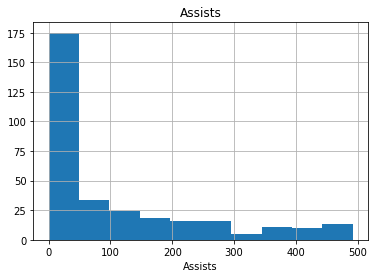

count   322.00
mean      8.04
std       6.37
min       0.00
5%        0.00
10%       1.00
20%       3.00
30%       4.00
40%       5.00
50%       6.00
60%       8.00
70%      10.00
80%      13.00
90%      17.00
95%      20.00
99%      25.79
100%     32.00
max      32.00
Name: Errors, dtype: float64


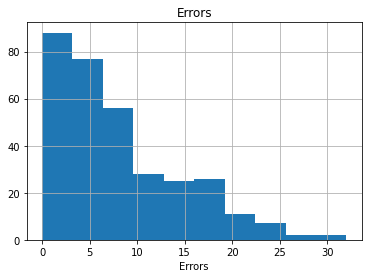

count    263.00
mean     535.93
std      451.12
min       67.50
5%        86.60
10%      100.00
20%      155.00
30%      221.00
40%      300.00
50%      425.00
60%      538.00
70%      700.00
80%      809.00
90%     1048.67
95%     1346.00
99%     2032.89
100%    2460.00
max     2460.00
Name: Salary, dtype: float64


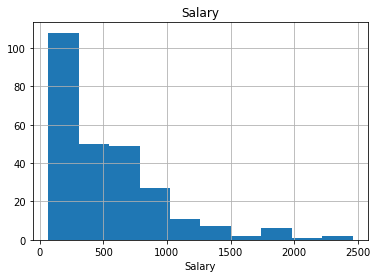

In [7]:
def numSummary(dataframe, numericalCol, plot=False):
    quantiles = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    print(dataframe[numericalCol].describe(quantiles).T)
    
    if plot:
        dataframe[numericalCol].hist()
        plt.xlabel(numericalCol)
        plt.title(numericalCol)
        plt.show(block=True)

for col in numCols:
    numSummary(df, col, True)

In [8]:
dfLowSalary = df[df['Salary'] < 200]
dfLowSalary["Errors"]

4       4
6       7
7       9
8      19
17     16
       ..
294    11
301    20
309     9
314    11
315    15
Name: Errors, Length: 69, dtype: int64

<AxesSubplot:xlabel='Salary', ylabel='Errors'>

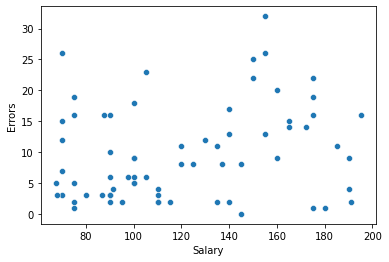

In [9]:
sns.scatterplot(x="Salary", y="Errors", data=dfLowSalary)

# Hedef Değişken Analizi

In [10]:
def targetSummaryWithNum(dataframe, target, numCol):
    print(dataframe.groupby(target).agg({numCol: "mean"}), end="\n\n\n")
for col in numCols:
    targetSummaryWithNum(df, "Salary", col)

         AtBat
Salary        
67.50   181.00
68.00   209.00
70.00   248.60
75.00   236.40
80.00   399.00
...        ...
1940.00 514.00
1975.00 677.00
2127.33  20.00
2412.50 618.00
2460.00 495.00

[150 rows x 1 columns]


          Hits
Salary        
67.50    41.00
68.00    54.00
70.00    57.40
75.00    58.20
80.00   102.00
...        ...
1940.00 144.00
1975.00 238.00
2127.33   1.00
2412.50 200.00
2460.00 151.00

[150 rows x 1 columns]


         HmRun
Salary        
67.50     1.00
68.00     3.00
70.00     3.20
75.00     3.00
80.00     3.00
...        ...
1940.00   0.00
1975.00  31.00
2127.33   0.00
2412.50  20.00
2460.00  17.00

[150 rows x 1 columns]


          Runs
Salary        
67.50    15.00
68.00    25.00
70.00    27.80
75.00    25.20
80.00    56.00
...        ...
1940.00  67.00
1975.00 117.00
2127.33   0.00
2412.50  98.00
2460.00  61.00

[150 rows x 1 columns]


           RBI
Salary        
67.50    21.00
68.00    14.00
70.00    22.40
75.00    22.80
80.00    34.00
...        

In [11]:
def targetSummaryWithCat(dataframe, target, numCol):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(numCol)[target].mean()}), end="\n\n\n")
for col in catCols:
    targetSummaryWithCat(df, "Salary", col)

        TARGET_MEAN
League             
A            542.00
N            529.12


          TARGET_MEAN
Division             
E              624.27
W              450.88


           TARGET_MEAN
NewLeague             
A               537.11
N               534.55




# Korelasyon Analizi

In [12]:
df.corr()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
AtBat,1.00,0.97,0.59,0.91,0.82,0.67,0.05,0.24,0.25,0.24,0.27,0.24,0.17,0.32,0.35,0.35,0.39
Hits,0.97,1.00,0.56,0.92,0.81,0.64,0.04,0.23,0.26,0.20,0.26,0.23,0.15,0.31,0.32,0.31,0.44
HmRun,0.59,0.56,1.00,0.65,0.86,0.48,0.12,0.22,0.22,0.49,0.26,0.35,0.23,0.28,-0.11,0.04,0.34
Runs,0.91,0.92,0.65,1.00,0.80,0.73,0.00,0.19,0.20,0.23,0.25,0.21,0.18,0.28,0.22,0.24,0.42
RBI,0.82,0.81,0.86,0.80,1.00,0.62,0.15,0.29,0.31,0.44,0.32,0.39,0.25,0.34,0.11,0.19,0.45
Walks,0.67,0.64,0.48,0.73,0.62,1.00,0.14,0.28,0.28,0.33,0.34,0.31,0.42,0.30,0.15,0.13,0.44
Years,0.05,0.04,0.12,0.00,0.15,0.14,1.00,0.92,0.90,0.73,0.88,0.87,0.84,-0.00,-0.08,-0.16,0.40
CAtBat,0.24,0.23,0.22,0.19,0.29,0.28,0.92,1.00,1.00,0.80,0.98,0.95,0.91,0.06,0.00,-0.07,0.53
CHits,0.25,0.26,0.22,0.20,0.31,0.28,0.90,1.00,1.00,0.78,0.98,0.95,0.89,0.08,-0.00,-0.06,0.55
CHmRun,0.24,0.20,0.49,0.23,0.44,0.33,0.73,0.80,0.78,1.00,0.82,0.93,0.80,0.11,-0.16,-0.14,0.52


In [13]:
def highCorrelatedCols(dataframe,plot=False,corrTh=0.90):
    corr=dataframe.corr()
    corrMatrix=corr.abs()
    upperTriangleMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
    dropList = [col for col in upperTriangleMatrix.columns if any(upperTriangleMatrix[col] > 0.90)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={"figure.figsize": (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return dropList

dropList = highCorrelatedCols(df)
dropList


['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

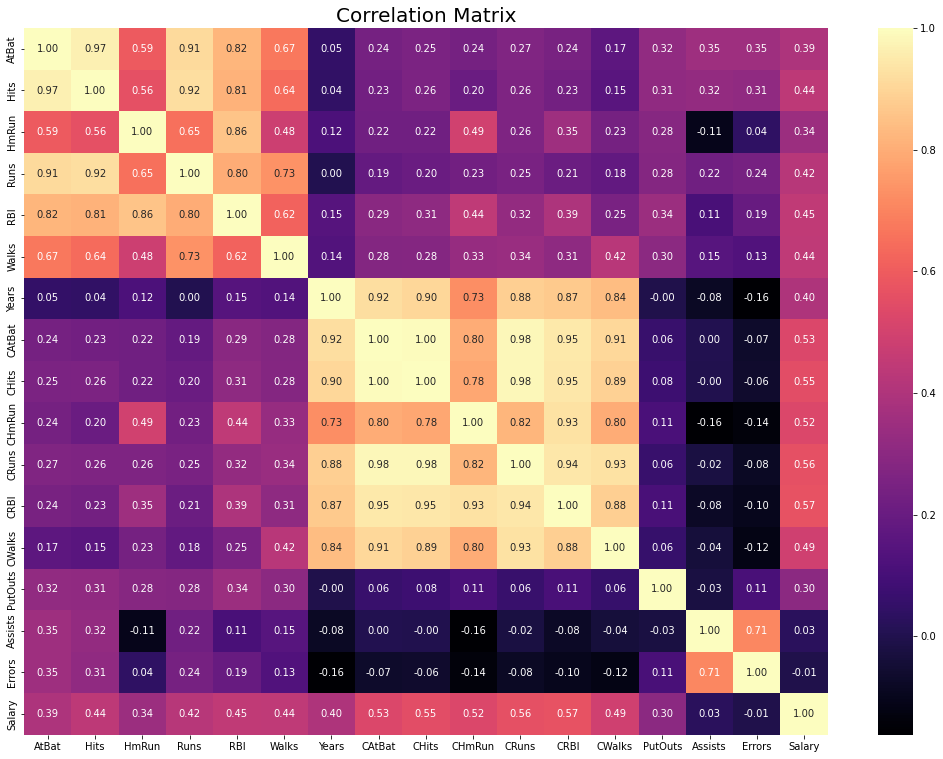

In [14]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[numCols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# Eksik Gözlemlerin Analizi

In [15]:
df.isnull().any()

AtBat        False
Hits         False
HmRun        False
Runs         False
RBI          False
Walks        False
Years        False
CAtBat       False
CHits        False
CHmRun       False
CRuns        False
CRBI         False
CWalks       False
League       False
Division     False
PutOuts      False
Assists      False
Errors       False
Salary        True
NewLeague    False
dtype: bool

In [16]:
def missingValuesTable(dataframe,naName = False):
    naColums = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    nMiss = dataframe[naColums].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[naColums].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missingDf = pd.concat([nMiss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missingDf,end='\n')
    if naName:
        return naColums

naColumns = missingValuesTable(df,True)


        n_miss  ratio
Salary      59  18.32


In [17]:
imputer = KNNImputer(n_neighbors=5)

In [18]:
df[numCols] = pd.DataFrame(imputer.fit_transform(df[numCols]), columns=numCols)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293.00,66.00,1.00,30.00,29.00,14.00,1.00,293.00,66.00,1.00,30.00,29.00,14.00,A,E,446.00,33.00,20.00,84.50,A
1,315.00,81.00,7.00,24.00,38.00,39.00,14.00,3449.00,835.00,69.00,321.00,414.00,375.00,N,W,632.00,43.00,10.00,475.00,N
2,479.00,130.00,18.00,66.00,72.00,76.00,3.00,1624.00,457.00,63.00,224.00,266.00,263.00,A,W,880.00,82.00,14.00,480.00,A
3,496.00,141.00,20.00,65.00,78.00,37.00,11.00,5628.00,1575.00,225.00,828.00,838.00,354.00,N,E,200.00,11.00,3.00,500.00,N
4,321.00,87.00,10.00,39.00,42.00,30.00,2.00,396.00,101.00,12.00,48.00,46.00,33.00,N,E,805.00,40.00,4.00,91.50,N


# Aykırı Değer Analizi

In [47]:
def outlierThresholds(dataframe, colName, q1=0.25, q3=0.75):
    quartile1 = dataframe[colName].quantile(q1)
    quartile3 = dataframe[colName].quantile(q3)
    interquantileRange = quartile3 - quartile1
    upLimit = quartile3 + 1.5 * interquantileRange
    lowLimit = quartile1 - 1.5 * interquantileRange
    return lowLimit, upLimit

def checkOutlier(dataframe, colName):
    lowLimit, upLimit = outlierThresholds(dataframe, colName)
    if dataframe[(dataframe[colName] > upLimit) | (dataframe[colName] < lowLimit)].any(axis=None):
        return True
    else:
        return False
def replaceWithThresholds(dataframe, colName):
    low, up = outlierThresholds(dataframe, colName)

    dataframe.loc[dataframe[colName] > up, colName] = up
    dataframe.loc[dataframe[colName] < low, colName] = low

for col in numCols:
    print(col,checkOutlier(df, col))
    if checkOutlier(df, col):
        replaceWithThresholds(df, col)

ATBAT False
HITS False
HMRUN False
RUNS False
RBI False
WALKS False
YEARS False
CATBAT False
CHITS False
CHMRUN False
CRUNS False
CRBI False
CWALKS False
PUTOUTS False
ASSISTS False
ERRORS False
SALARY False
NEW_CAREER_YEARS False
NEW_RUNS_ATBAT False
NEW_ERRORS_RBI False
NEW_RUNS_YEARS False


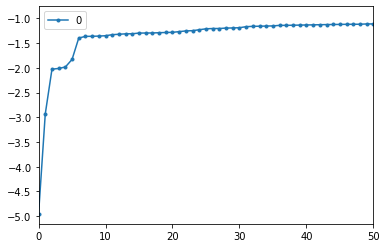

[-4.95571311 -2.93262983 -2.02795011 -2.012755   -1.98343109 -1.83047826
 -1.39717115 -1.36378404 -1.36201942 -1.35779008]
th: -2.027950112474544
(2, 20)


In [20]:
clf=LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df[numCols])
df_scores = clf.negative_outlier_factor_
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True,xlim=[0,50],style=".-")
plt.show()
print(np.sort(df_scores)[0:10])
th = np.sort(df_scores)[2]
print(f'th: {th}')
print(df[df_scores < th].shape)

In [ ]:
df[df_scores < th].index

In [ ]:
df.drop(axis=0, labels=df[df_scores < th].index, inplace=True)

# Base Model Kurulumu


In [26]:
dff = df.copy()
def one_hot_encoder(dataframe, categoricalCols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categoricalCols, drop_first=drop_first)
    return dataframe


dff = one_hot_encoder(dff, catCols, drop_first=True)
y = dff["Salary"]
X = dff.drop(["Salary"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=159)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred = lin_model.predict(X_test)

lin_model.score(X_test, y_test)


0.6750230821350279

In [27]:
# Train RMSE
yPred = lin_model.predict(X_train)
np.sqrt((mean_squared_error(y_train, yPred)))

229.08174661146833

In [28]:
# Test RMSE
yPred = lin_model.predict(X_test)
np.sqrt((mean_squared_error(y_test, yPred)))

253.59961072567535

In [29]:
# Train RKARE
lin_model.score(X_train, y_train)

0.5659626989283189

In [30]:
# Test RKARE
lin_model.score(X_test, y_test)

0.6750230821350279

# Özellik Çıkarımı

In [31]:
df.columns = [col.upper() for col in df.columns]
# Oyuncunun Tecrübe Durumu
df["NEW_YEARS_CAT"] = pd.cut(x=df["YEARS"], bins=[0, 5, 10, 15], labels=["rookie", "experienced", "veteran"])
df['NEW_CAREER_YEARS'] = (df['CATBAT'] + df['CHITS'] + df['CHMRUN'] + df['CRUNS'] + df['CRBI'] + df['CWALKS']) / df['YEARS']
# Oyuncunun kariyeri boyunca yaptığı başarılı işlerin oynadığı süreye göre ortalaması
# Oyuncunun home run puanı alabilme kabiliyeti
df.loc[df['HMRUN'] >= 10, 'NEW_HMRUN_CAT'] = 'homerunner'
df.loc[df['HMRUN'] < 10, 'NEW_HMRUN_CAT'] = 'not_homerunner'
# Oyuncunun 1986-1987 yıllarındaki vuruşlarını skora çevirme oranı
df['NEW_RUNS_ATBAT'] = df['RUNS'] / df['ATBAT']

# Oyuncunun 1986-1987 yıllarındaki net hata katkısı
df['NEW_ERRORS_RBI'] = df['WALKS'] - df['ERRORS']
# Oyuncunun tecrübe ve takıma katkısının çarpımı
df['NEW_RUNS_YEARS'] = df['RUNS'] * df['YEARS']
catCols, numCols, catButCar = grabColNames(df)

Observations: 320
Variables: 26
catCols: 5
numCols: 21
catButCar: 0
numButCat: 1


# Encoding

In [32]:
def labelEncoder(dataframe, binaryCol):
    labelencoder = LabelEncoder()
    dataframe[binaryCol] = labelencoder.fit_transform(dataframe[binaryCol])
    return dataframe

binaryCols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binaryCols

['LEAGUE', 'DIVISION', 'NEWLEAGUE', 'NEW_HMRUN_CAT']

In [34]:
for col in binaryCols:
    df = labelEncoder(df, col)
catCols

['LEAGUE', 'DIVISION', 'NEWLEAGUE', 'NEW_HMRUN_CAT', 'NEW_YEARS_CAT']

In [35]:
df = one_hot_encoder(df, catCols, drop_first=True)

# Scaling

In [36]:
scaler = MinMaxScaler()
df[numCols] = scaler.fit_transform(df[numCols])
df.head()

,ATBAT,HITS,HMRUN,RUNS,RBI,WALKS,YEARS,CATBAT,CHITS,CHMRUN,...,NEW_CAREER_YEARS,NEW_RUNS_ATBAT,NEW_ERRORS_RBI,NEW_RUNS_YEARS,LEAGUE_1,DIVISION_1,NEWLEAGUE_1,NEW_HMRUN_CAT_1,NEW_YEARS_CAT_experienced,NEW_YEARS_CAT_veteran
0,0.41,0.27,0.03,0.23,0.24,0.14,0.00,0.03,0.03,0.00,...,0.41,0.32,0.05,0.02,0,0,0,1,0,0
1,0.45,0.33,0.21,0.18,0.32,0.39,0.63,0.40,0.36,0.34,...,0.37,0.18,0.39,0.21,1,1,1,1,0,1
2,0.69,0.54,0.53,0.52,0.60,0.76,0.10,0.19,0.19,0.31,...,0.93,0.50,0.71,0.12,0,1,0,0,0,0
3,0.72,0.59,0.59,0.51,0.65,0.37,0.49,0.65,0.67,1.00,...,0.83,0.47,0.44,0.45,1,0,1,0,0,1
4,0.45,0.36,0.29,0.30,0.35,0.30,0.05,0.04,0.04,0.06,...,0.30,0.42,0.36,0.05,1,0,1,0,0,0


# Modelleme

In [37]:

y = df["SALARY"]
X = df.drop(["SALARY"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=159)

reg_model = LinearRegression().fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

reg_model.score(X_test, y_test)

0.7127301155265926

In [38]:
reg_model.intercept_

0.21810648878880728

In [39]:
reg_model.coef_

array([-5.81661243e-01,  1.75022750e-01, -6.75736072e-02,  8.41151175e-01,
       -3.60224491e-02,  2.20578392e-02, -2.11779353e-01, -5.20583391e-01,
        5.12015265e-01,  1.18133180e-01,  1.45641371e-01,  2.43438737e-01,
        2.22142548e-02,  7.96490303e-02,  1.69303242e-02, -4.69341627e-02,
        1.65252256e-01, -5.48275315e-01,  3.17887450e-02,  2.14275906e-02,
        1.93034989e-04, -2.91871227e-02, -7.60307468e-03, -1.58165407e-02,
        1.56628156e-01,  9.62538184e-02])

    Value                    Feature
3    0.84                       RUNS
8    0.51                      CHITS
11   0.24                       CRBI
1    0.18                       HITS
16   0.17           NEW_CAREER_YEARS
24   0.16  NEW_YEARS_CAT_experienced
10   0.15                      CRUNS
9    0.12                     CHMRUN
25   0.10      NEW_YEARS_CAT_veteran
13   0.08                    PUTOUTS
18   0.03             NEW_ERRORS_RBI
12   0.02                     CWALKS
5    0.02                      WALKS
19   0.02             NEW_RUNS_YEARS
14   0.02                    ASSISTS
20   0.00                   LEAGUE_1
22  -0.01                NEWLEAGUE_1
23  -0.02            NEW_HMRUN_CAT_1
21  -0.03                 DIVISION_1
4   -0.04                        RBI
15  -0.05                     ERRORS
2   -0.07                      HMRUN
6   -0.21                      YEARS
7   -0.52                     CATBAT
17  -0.55             NEW_RUNS_ATBAT
0   -0.58                      ATBAT


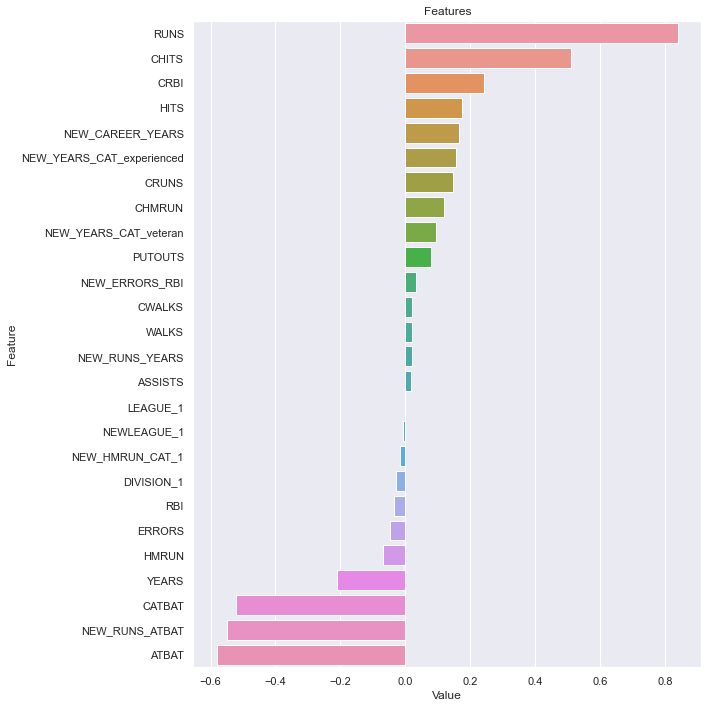

In [40]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.coef_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value", ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
plot_importance(reg_model,X)

In [41]:
# Train RMSE
y_pred=reg_model.predict(X_train)
np.sqrt((mean_squared_error(y_train, y_pred)))

0.1368804666505278

In [42]:
# Test RMSE
y_pred=reg_model.predict(X_test)
np.sqrt((mean_squared_error(y_test, y_pred)))

0.15954068608305533

In [43]:
# Train RKARE
reg_model.score(X_train,y_train)

0.6538846376472665

In [44]:
# Test RKARE
reg_model.score(X_test,y_test)

0.7127301155265926

In [45]:
# 10 katlı Cross Validation
np.mean(np.sqrt(-cross_val_score(reg_model,X,y,cv=10,scoring="neg_mean_absolute_error")))

0.33711594702043335